In [1]:
import arrayfire as af
import numpy as np
import pylab as pl
%matplotlib inline

In [2]:
from bolt.lib.physical_system import physical_system
from bolt.lib.nonlinear_solver.nonlinear_solver import nonlinear_solver
from bolt.lib.linear_solver.linear_solver import linear_solver

In [3]:
import domain
import boundary_conditions
import params
import initialize

In [4]:
import bolt.src.nonrelativistic_boltzmann.advection_terms as advection_terms
import bolt.src.nonrelativistic_boltzmann.collision_operator as collision_operator
import bolt.src.nonrelativistic_boltzmann.moment_defs as moment_defs

In [5]:
# Optimized plot parameters to make beautiful plots:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['figure.dpi']      = 75
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

In [6]:
# Defining the physical system to be solved:
system = physical_system(domain,
                         boundary_conditions,
                         params,
                         initialize,
                         advection_terms,
                         collision_operator.BGK,
                         moment_defs
                        )

N_g = system.N_ghost

N_q1 = 2 , N_q2 = 2 , N_p1 = 32 , N_p2 = 32


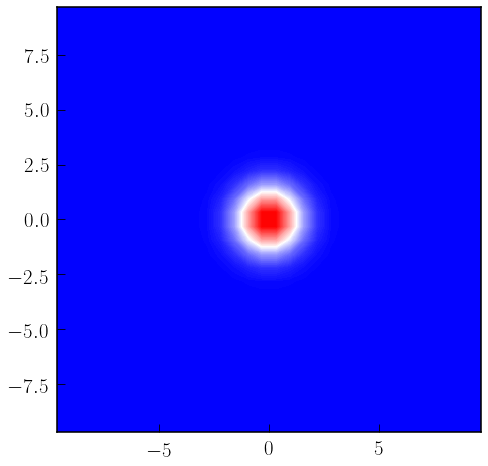

In [7]:
# Declaring a linear system object which will evolve the defined physical system:
nls = nonlinear_solver(system)
ls  = linear_solver(system)

print("N_q1 =", nls.N_q1, ", N_q2 =", nls.N_q2, ", N_p1 =", nls.N_p1, ", N_p2 =", nls.N_p2)

p1 = np.array(af.moddims(nls.p1, nls.N_p1, nls.N_p2))
p2 = np.array(af.moddims(nls.p2, nls.N_p1, nls.N_p2))

f_at_desired_q_initial = af.moddims(nls.f[:, N_g, N_g + nls.N_q2/2],
                            nls.N_p1, nls.N_p2
                           )

pl.contourf(p1, p2, np.array(f_at_desired_q_initial), 100, cmap='bwr')
pl.gca().set_aspect('equal')

In [8]:
# Time parameters:
dt      = 0.001 * 32/nls.N_p1
t_final = 0.002 

time_array  = np.arange(0, t_final + dt, dt)

rho_data_nls = np.zeros(time_array.size)
rho_data_ls  = np.zeros(time_array.size)

In [9]:
# Storing data at time t = 0:
n_nls           = nls.compute_moments('density')
rho_data_nls[0] = af.max(n_nls[:, N_g:-N_g, N_g:-N_g])

n_ls           = ls.compute_moments('density')
rho_data_ls[0] = af.max(n_ls) 

In [10]:
f = []
f.append(nls.f)

for time_index, t0 in enumerate(time_array[1:]):
    print("time_index = ", time_index, " of ", time_array.size-2, " t = ", t0)
    nls.strang_timestep(dt)
    ls.RK4_timestep(dt)
    f.append(nls.f)

    n_nls                         = nls.compute_moments('density')
    rho_data_nls[time_index + 1]  = af.max(n_nls[:, N_g:-N_g, N_g:-N_g])
    
    n_ls                        = ls.compute_moments('density')
    rho_data_ls[time_index + 1] = af.max(n_ls) 

time_index =  0  of  1  t =  0.001
time_index =  1  of  1  t =  0.002


In [11]:
# pl.plot(time_array, rho_data_ls, '--', color = 'black', label = 'Linear Solver')
# pl.plot(time_array, rho_data_nls, label='Nonlinear Solver')
# pl.ylabel(r'MAX($\rho$)')
# pl.xlabel('Time')
# pl.legend()

In [12]:
# f_at_desired_q = af.moddims(f[60][:, N_g, N_g + nls.N_q2/2],
#                             nls.N_p1, nls.N_p2
#                            )

#f_initial_at_desired_q = \
#    initialize.initialize_f(nls.q1_center, nls.q2_center, nls.p1, nls.p2, nls.p3, params)
    
#f_initial_at_desired_q = af.moddims(f_initial_at_desired_q,
#                                    nls.N_p1, nls.N_p2
#                                   )


# pl.contourf(p1, p2, np.array(f_at_desired_q), 100, cmap='bwr')
# pl.gca().set_aspect('equal')

In [13]:
nls.f[:, nls.N_ghost, nls.N_ghost + nls.N_q2/2].shape

(1024,)

In [14]:
# for i in range(400):
#     f_at_desired_q = af.moddims(f[i][:, N_g, N_g + nls.N_q2/2],
#                                 nls.N_p1, nls.N_p2
#                                )

#     pl.contourf(p1, p2, np.array(f_at_desired_q), 100, cmap='bwr')
#     pl.title('Time = %.3f'%(i*1e-3))
#     pl.gca().set_aspect('equal')
#     pl.savefig('images/%04d'%i+'.png')
#     pl.clf()

In [15]:
# import os
# os.system('cd images;ffmpeg -f image2 -i %04d.png -vcodec mpeg4 -mbd rd -trellis 2 -cmp 2 -g 300 -pass 1 -r 25 -b 18000000 movie.mp4')

In [16]:
error = af.mean(af.abs(f[time_array.size - 1][:, N_g, N_g + nls.N_q2/2] - f[0][:, N_g, N_g + nls.N_q2/2]))
print(error)

4.869645352133559e-06
